pip install diffusers accelerate

In [1]:
!pip install diffusers
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.3/297.3 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [ ]:
import torch
from diffusers import StableDiffusionXLImg2ImgPipeline, DiffusionPipeline, KDPM2AncestralDiscreteScheduler, StableDiffusionXLPipeline, AutoencoderKL
import gc
from PIL import Image
import requests
from io import BytesIO
from IPython.display import display
import torch
from huggingface_hub import notebook_login
from transformers import pipeline

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

####Checking prompt is comic friendly or not

In [ ]:
sentiment_pipeline = pipeline("sentiment-analysis")

def refine_prompt(prompt):
    result = sentiment_pipeline(prompt)[0]
    if result['label'] == 'POSITIVE' and result['score'] > 0.75:
        print(result['label'], result['score'])
        return True, prompt
    else:
        return False, "Prompt does not match comic-friendly criteria."

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

####**Model: runwayml/stable-diffusion-v1-5**

In [ ]:
from diffusers import StableDiffusionPipeline
import torch

model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

n_steps = 40
high_noise_frac = 0.8

prompt = "A small, warm house in the snow, with light shining from the windows and smoke rising from the chimney, 8K, full image"

image = pipe(
              prompt=prompt,
              num_inference_steps=n_steps,
              denoising_end=high_noise_frac,
            ).images[0]


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

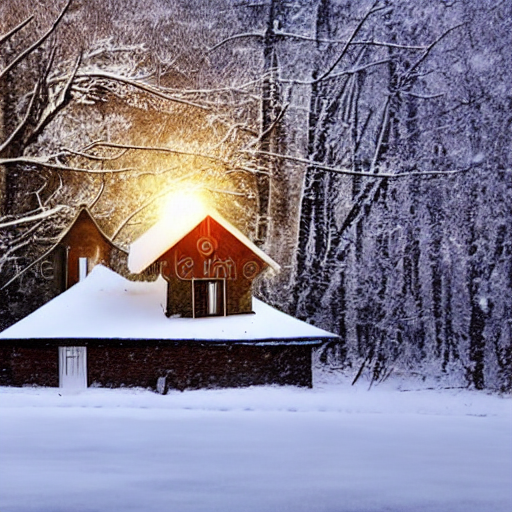

In [ ]:
image

####**Model: stabilityai/stable-diffusion-xl-base-1.0**

In [ ]:
# load both base & refiner
base = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
)
base.to("cuda")
refiner = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0",
    text_encoder_2=base.text_encoder_2,
    vae=base.vae,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
)
refiner.to("cuda")

# Define how many steps and what % of steps to be run on each experts (80/20) here
n_steps = 40
high_noise_frac = 0.8

prompt = "A small, warm house in the snow, with light shining from the windows and smoke rising from the chimney, 8K"

# run both experts
image = base(
    prompt=prompt,
    num_inference_steps=n_steps,
    denoising_end=high_noise_frac,
    output_type="latent",
).images
image = refiner(
    prompt=prompt,
    num_inference_steps=n_steps,
    denoising_start=high_noise_frac,
    image=image,
).images[0]


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

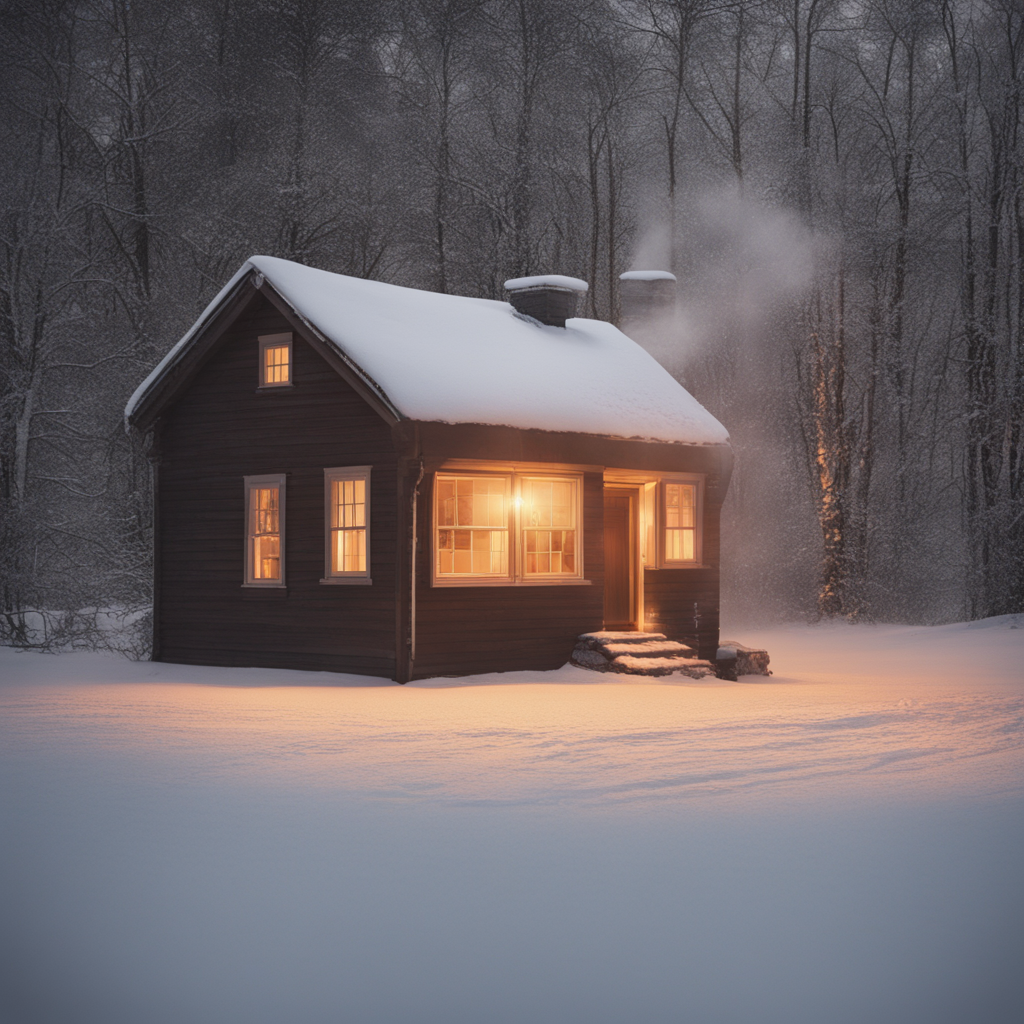

In [ ]:
image

####**Model: playgroundai/playground-v2.5-1024px-aesthetic**

In [ ]:
pipe = DiffusionPipeline.from_pretrained(
    "playgroundai/playground-v2.5-1024px-aesthetic",
    torch_dtype=torch.float16,
    variant="fp16",
).to("cuda")

prompt = "A small, warm house in the snow, with light shining from the windows and smoke rising from the chimney"
aimage_playai = pipe(prompt=prompt, num_inference_steps=50, guidance_scale=3).images[0]


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

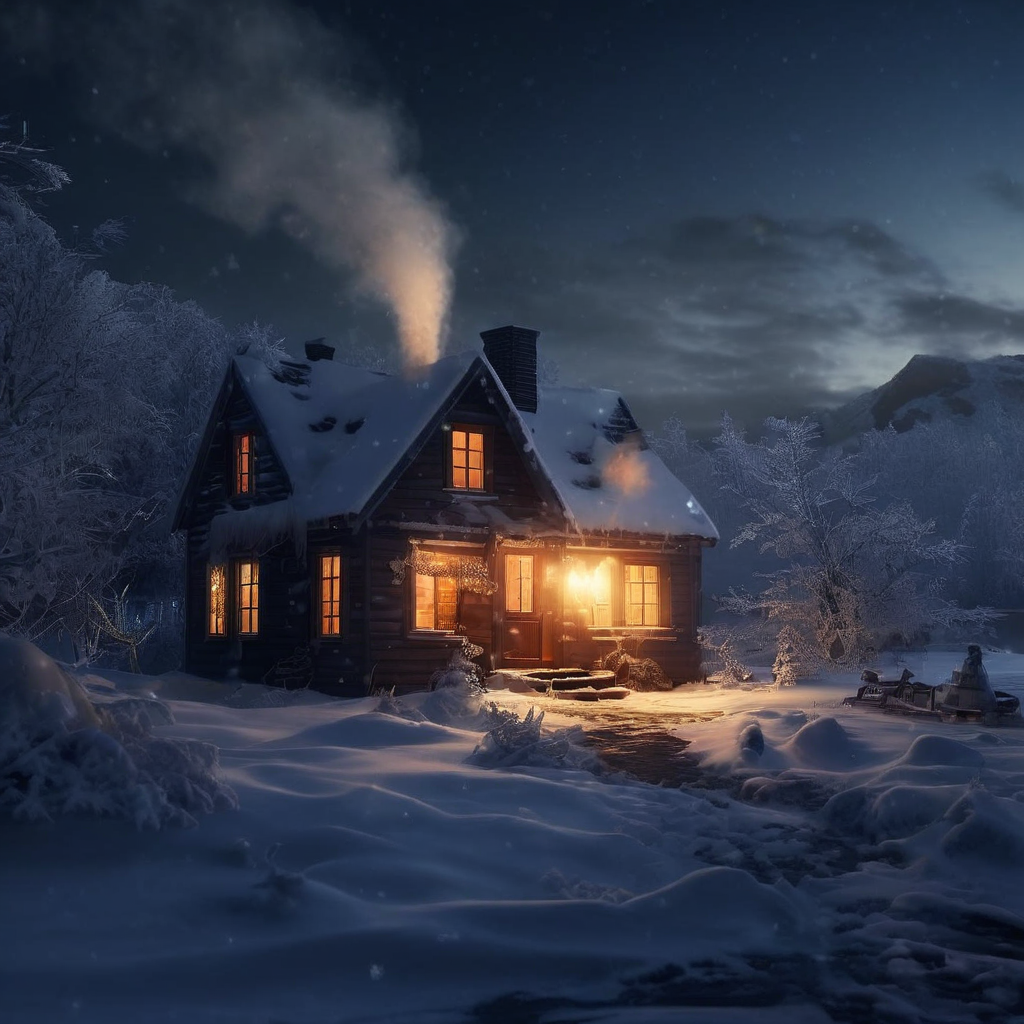

In [ ]:
image_playai

####**Model: stabilityai/stable-diffusion-2-1**

In [ ]:
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler

model_id = "stabilityai/stable-diffusion-2-1"

# Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

prompt = "A small, warm house in the snow, with light shining from the windows and smoke rising from the chimney, 8K"
image_stabai = pipe(prompt).images[0]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

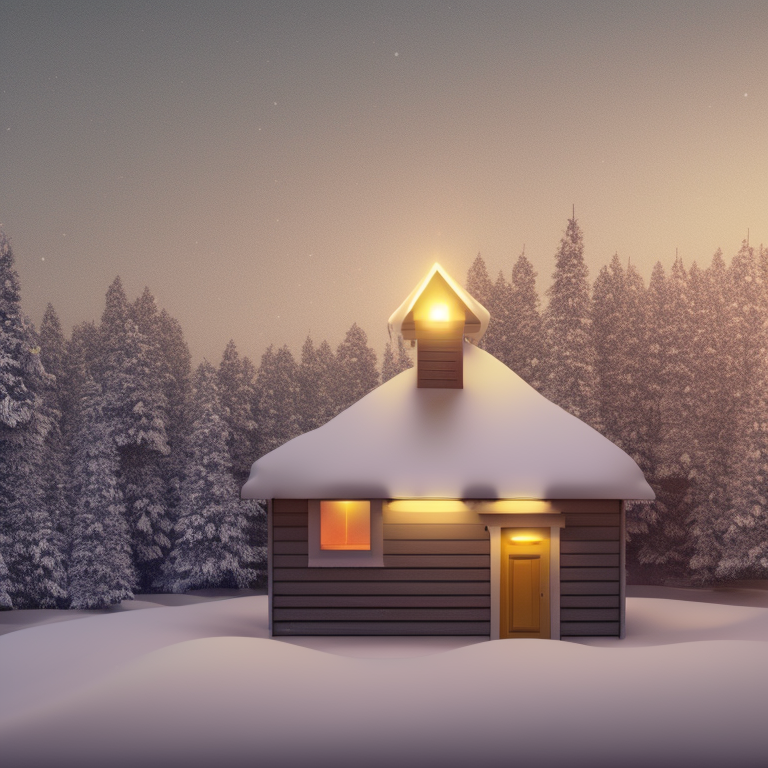

In [ ]:
image_stabai

In [ ]:
def is_educational(prompt):
    # List of keywords indicative of educational content
    educational_keywords = [
        'explain', 'demonstrate', 'illustrate', 'what is', 'how does',
        'history of', 'science behind', 'mathematics of', 'educational',
        'biology of', 'physics of', 'chemistry of', 'learn about'
    ]

    # Convert the prompt to lowercase to ensure the search is case-insensitive
    prompt_lower = prompt.lower()

    # Check if any of the educational keywords appear in the prompt
    for keyword in educational_keywords:
        if keyword in prompt_lower:
            return True  # The prompt is considered educational

    # If none of the keywords were found, the prompt is not considered educational
    return False

# # Example usage:
# prompt = "Draw a fantasy landscape with dragons flying over a castle on a mountain"
# if is_educational(prompt):
#     print("This prompt is educational.")
# else:
#     print("This prompt is not educational.")


This prompt is not educational.


In [ ]:
import re

def is_educational(prompt):
    educational_keywords = [
        'explain', 'demonstrate', 'illustrate', 'what is', 'how does',
        'history of', 'science behind', 'mathematics of', 'educational',
        'biology of', 'physics of', 'chemistry of', 'learn about'
    ]
    non_educational_keywords = [
        'fantasy', 'imagine', 'magical', 'legendary'
    ]
    educational_patterns = [
        r'\bhow to\b', r'\bwhy does\b', r'\bwhat are the\b',
        r'\bthe importance of\b', r'\bthe principles of\b'
    ]

    prompt_lower = prompt.lower()
    score = 0

    # Check for educational keywords
    for keyword in educational_keywords:
        if keyword in prompt_lower:
            score += 1

    # Check for non-educational keywords
    for keyword in non_educational_keywords:
        if keyword in prompt_lower:
            score -= 1  # Penalize the presence of non-educational keywords

    # Check for patterns indicating educational content
    for pattern in educational_patterns:
        if re.search(pattern, prompt_lower):
            score += 2  # Give more weight to pattern matches

    # Consider simple negations
    if "not" in prompt_lower:
        score -= 1

    # Define a threshold for considering a prompt educational
    threshold = 1  # Adjust based on testing and desired sensitivity
    return score >= threshold

# Example usage
prompt = "Tell us about the life of a butterfly from egg to adult"
print(is_educational(prompt))  # Expected: True

prompt = "Imagine a world where dragons are real."
print(is_educational(prompt))  # Expected: False


0
False
-1
False


In [ ]:
prompts = [
  "Tell us about the life of a butterfly from egg to adult",
  "Illustrate the process of evaporation and condensation in the water cycle.",
  "What is the significance of the Battle of Hastings in 1066?",
  "Explain Newton's laws of motion using everyday examples.",
  "Demonstrate how to solve a quadratic equation.",
  "The adventures of a magical unicorn in an enchanted forest.",
  "Create a story about a pirate searching for treasure on a deserted island.",
  "How does photosynthesis work in plants?",
  "What are the principles behind renewable energy sources?",
  "Imagine a future where cars fly and buildings float in the sky.",
  "The science behind baking a perfect loaf of bread.",
  "Why does the moon change phases throughout the month?",
  "A day in the life of a Roman gladiator.",
  "Draw a fantasy landscape with dragons flying over a castle.",
  "Explain the role of gut bacteria in human digestion."
]

In [ ]:
for prompt in prompts:
  print(prompt," --> ",is_educational(prompt))  # Expected: True


0
Tell us about the life of a butterfly from egg to adult  -->  False
1
Illustrate the process of evaporation and condensation in the water cycle.  -->  True
1
What is the significance of the Battle of Hastings in 1066?  -->  True
1
Explain Newton's laws of motion using everyday examples.  -->  True
3
Demonstrate how to solve a quadratic equation.  -->  True
-1
The adventures of a magical unicorn in an enchanted forest.  -->  False
0
Create a story about a pirate searching for treasure on a deserted island.  -->  False
1
How does photosynthesis work in plants?  -->  True
2
What are the principles behind renewable energy sources?  -->  True
-1
Imagine a future where cars fly and buildings float in the sky.  -->  False
1
The science behind baking a perfect loaf of bread.  -->  True
2
Why does the moon change phases throughout the month?  -->  True
0
A day in the life of a Roman gladiator.  -->  False
-1
Draw a fantasy landscape with dragons flying over a castle.  -->  False
1
Explain the

In [ ]:
from transformers import pipeline
from diffusers import DiffusionPipeline, DDIMScheduler
import torch

In [ ]:
def refine_prompt(original_prompt):
    # Add any specific adjustments to the prompt here
    # This is a simple example that ensures certain keywords are included
    # for better alignment with educational content
    refined_keywords = ["educational", "illustrative", "clear", "detailed"]
    for keyword in refined_keywords:
        if keyword not in original_prompt:
            original_prompt += f", {keyword}"
    return original_prompt

In [ ]:
def generate_educational_image(prompt, negative_prompt):


      pipe = DiffusionPipeline.from_pretrained(
          "playgroundai/playground-v2.5-1024px-aesthetic",
          torch_dtype=torch.float16,
          variant="fp16",
      ).to("cuda")

      negative_prompt = negative_prompt + " ugly, deformed, noisy, blurry, distorted, Avoid dark, night-time scenes, Do not use abstract art styles, Avoid violence, any form of discrimination, or explicit content"

      image = pipe(prompt=prompt, negative_prompt=negative_prompt, num_images_per_prompt=2, width=1024, height=1024, prompt_strength=0.8, num_inference_steps=50, guidance_scale=7, scheduler="DPMSolver++").images
      print(image)
      return image

In [ ]:
prompt = "Imagine a future where cars fly and buildings float in the sky."
negative_prompt = "Avoid cartoon characters, mythological elements, and unrelated scientific concepts like space travel or quantum physics."
# prompt = "Show a close-up of a honeybee pollinating a large sunflower, with the garden blurred in the background."
if is_educational(prompt):
  refinePrompt = refine_prompt(prompt)
  educational_image = generate_educational_image(refinePrompt, "")
else:
    print("Prompt is not educational-friendly.")
    educational_image = None


1


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[<PIL.Image.Image image mode=RGB size=1024x1024 at 0x791724431F60>, <PIL.Image.Image image mode=RGB size=1024x1024 at 0x791724432A70>]


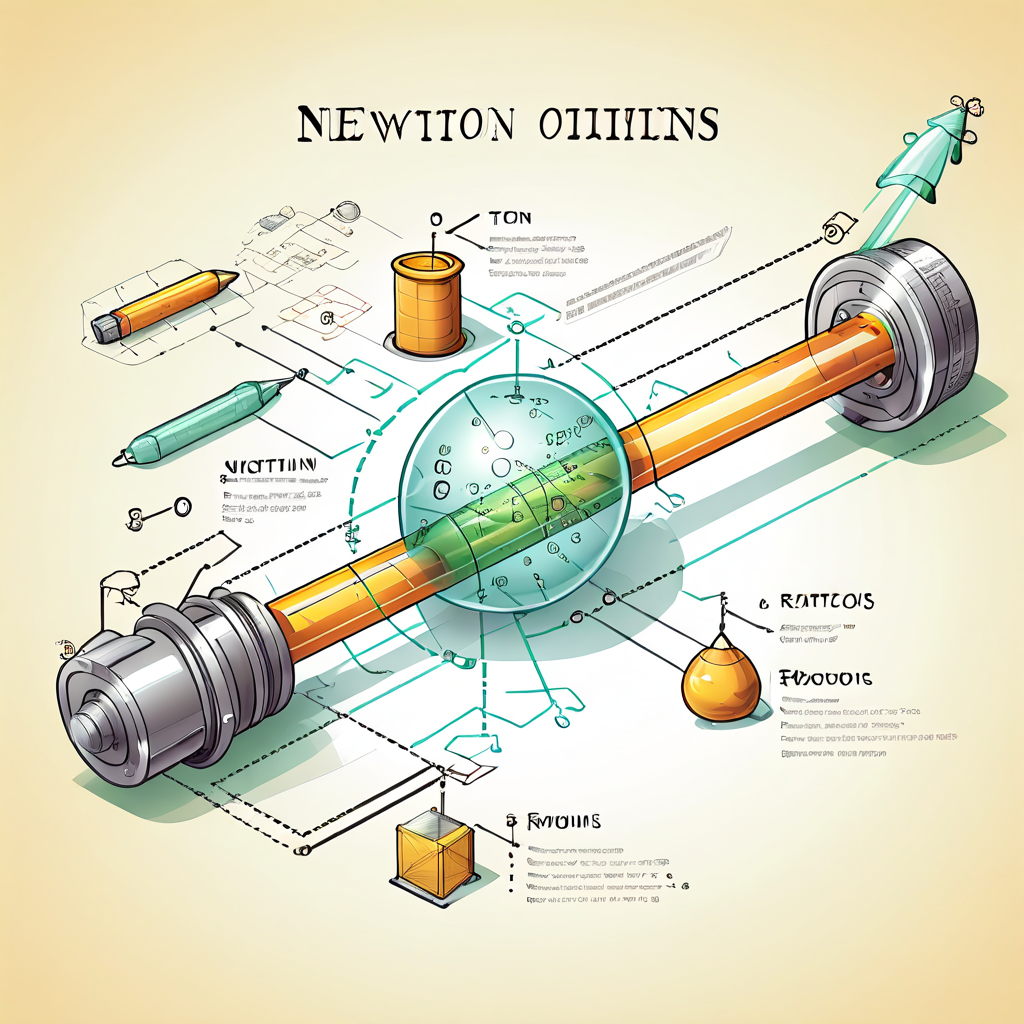

In [ ]:
educational_image[0]

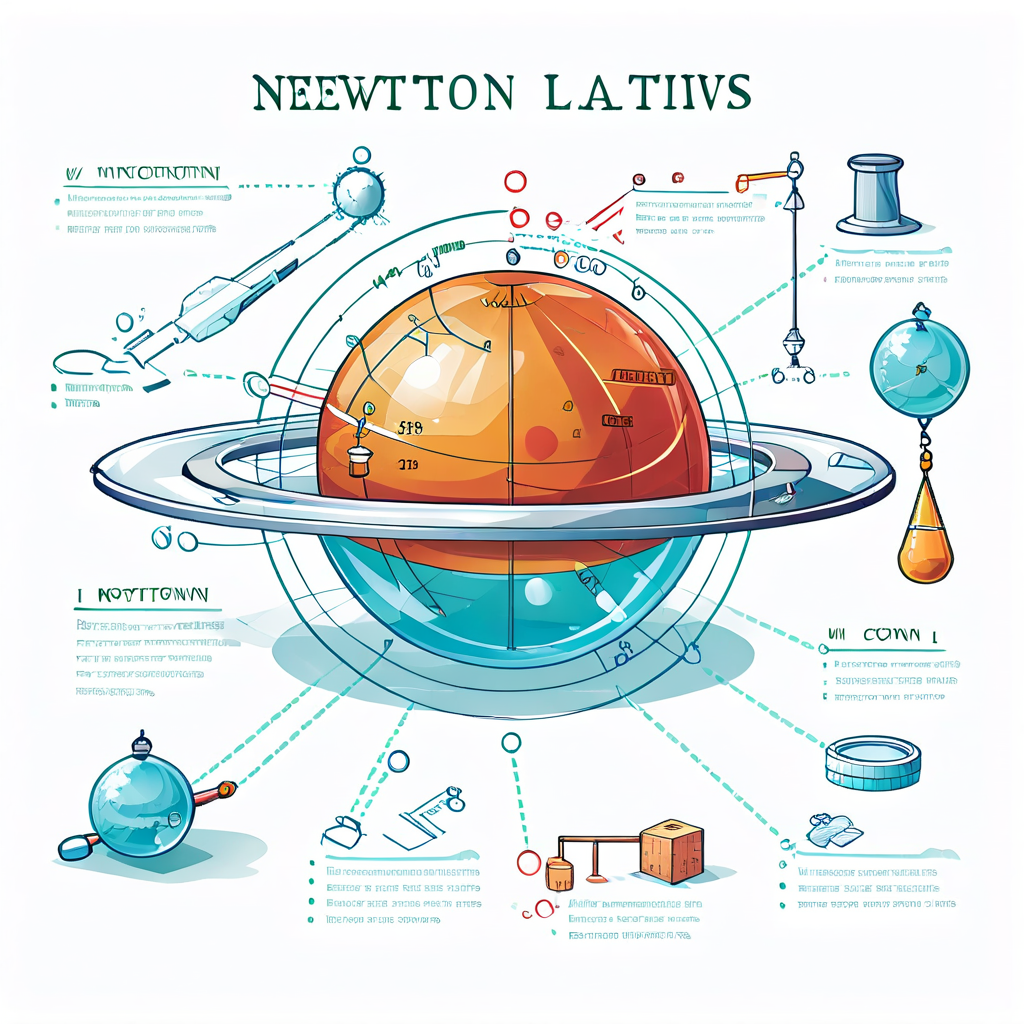

In [ ]:
educational_image[1]